# ML Data set


# Load the packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

/Users/eunbinkim/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load the cluster data 

In [2]:
#read the cluster data in parquet
odf = pd.read_parquet('clusterdata.parquet.snappy')

In [3]:
odf

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id
0,1.435010,-4.354630,4.58499,-1727.400,0,xy,0001,0
1,1.076120,-4.057220,4.19751,-1850.020,0,xy,0001,1
2,-4.315750,2.407100,4.94164,-2867.620,0,xy,0001,2
3,0.717368,-4.490940,4.54788,-1746.100,0,xy,0001,3
4,0.198263,-4.517540,4.52189,-1658.320,0,xy,0001,4
...,...,...,...,...,...,...,...,...
3207155,-2.366860,0.946819,2.54922,233.506,0,yz,2621,408
3207156,-2.756740,1.714310,3.24630,891.324,0,yz,2621,409
3207157,-4.548310,-1.665560,4.84368,217.310,3,yz,2621,410
3207158,-2.094290,1.472960,2.56040,1645.640,0,yz,2621,411


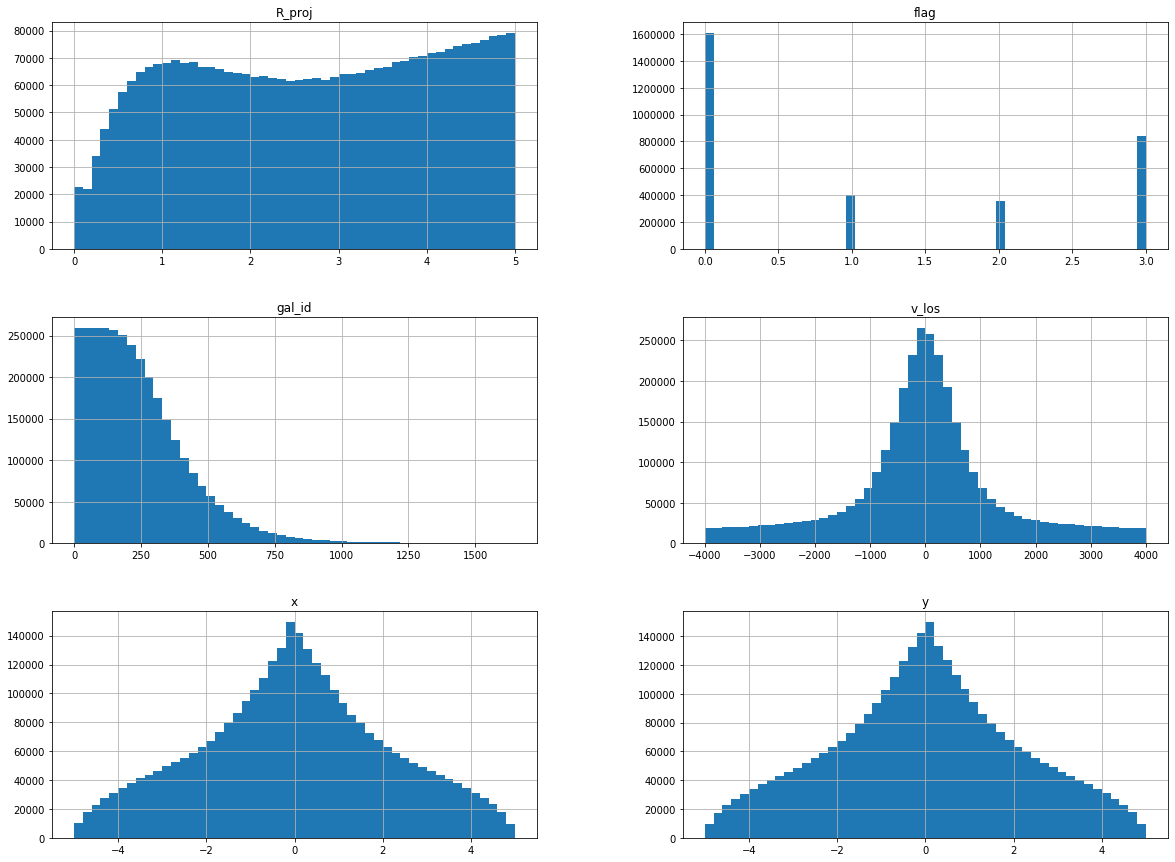

In [4]:
%matplotlib inline

odf.hist(bins=50,figsize=(20,15))
plt.show()

# Data set: selecting largest cluster 

In [5]:
#Check the largest cluster
odf.groupby('cluster_id').count().sort_values('gal_id').tail(100)

,x,y,R_proj,v_los,flag,proj_axis,gal_id
cluster_id,,,,,,,
0259,2134,2134,2134,2134,2134,2134,2134
2053,2135,2135,2135,2135,2135,2135,2135
0821,2142,2142,2142,2142,2142,2142,2142
0317,2143,2143,2143,2143,2143,2143,2143
1516,2145,2145,2145,2145,2145,2145,2145
...,...,...,...,...,...,...,...
1777,3430,3430,3430,3430,3430,3430,3430
1049,3449,3449,3449,3449,3449,3449,3449
0062,3453,3453,3453,3453,3453,3453,3453


In [6]:
grouped = odf.groupby('cluster_id')

In [7]:
len(grouped.groups.keys())

2621

In [8]:
len(odf['cluster_id'].unique())

2621

In [9]:
odf['cluster_id']

0          0001
1          0001
2          0001
3          0001
4          0001
           ... 
3207155    2621
3207156    2621
3207157    2621
3207158    2621
3207159    2621
Name: cluster_id, Length: 3207160, dtype: object

In [10]:
odf.columns

Index(['x', 'y', 'R_proj', 'v_los', 'flag', 'proj_axis', 'cluster_id',
       'gal_id'],
      dtype='object')

In [11]:
odf.dtypes

x             float64
y             float64
R_proj        float64
v_los         float64
flag            int64
proj_axis      object
cluster_id     object
gal_id          int64
dtype: object

In [12]:
#Add new column for type changed data
odf['cluster_id_num'] = odf['cluster_id'].apply(lambda x: np.int(x))

In [13]:
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207160 entries, 0 to 3207159
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   x               float64
 1   y               float64
 2   R_proj          float64
 3   v_los           float64
 4   flag            int64  
 5   proj_axis       object 
 6   cluster_id      object 
 7   gal_id          int64  
 8   cluster_id_num  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 220.2+ MB


In [14]:
odf.dtypes

x                 float64
y                 float64
R_proj            float64
v_los             float64
flag                int64
proj_axis          object
cluster_id         object
gal_id              int64
cluster_id_num      int64
dtype: object

In [15]:
# Change the flag = 1,2,3 to flag = 1
# add new column for saving changed flag
odf['label'] = odf['flag'].apply(lambda x: np.int(1) if x>0 else x)

In [16]:
odf.count()

x                 3207160
y                 3207160
R_proj            3207160
v_los             3207160
flag              3207160
proj_axis         3207160
cluster_id        3207160
gal_id            3207160
cluster_id_num    3207160
label             3207160
dtype: int64

In [17]:
odf[20:30].head()

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id,cluster_id_num,label
20,3.327570,-1.570310,3.67949,-2576.660,0,xy,0001,20,1,0
21,0.718293,1.638470,1.78900,-940.767,0,xy,0001,21,1,0
22,-1.264730,-3.909430,4.10891,-2040.360,0,xy,0001,22,1,0
23,-1.646460,4.176180,4.48902,-1043.470,0,xy,0001,23,1,0
24,-1.767460,0.778044,1.93113,-3759.240,0,xy,0001,24,1,0


In [18]:
# Check the changed flag
pd.crosstab(odf.flag,odf.flag).sum().sum()

3207160

In [19]:
odf.flag.unique()

array([0, 3, 1, 2])

In [20]:
# Extract the largest cluster
testdf = grouped.get_group('1562')
#testdf = grouped.get_group('0259')
#testdf = grouped.get_group('2053')
#testdf = grouped.get_group('2152')

In [21]:
testdf

,x,y,R_proj,v_los,flag,proj_axis,cluster_id,gal_id,cluster_id_num,label
310436,3.206740,-3.62396,4.83903,-991.9510,0,xy,0259,0,259,0
310437,-0.737515,-4.85388,4.90959,-2131.6500,0,xy,0259,1,259,0
310438,1.164710,3.09319,3.30520,-3665.4400,0,xy,0259,2,259,0
310439,1.844650,-4.15882,4.54956,-2136.5900,0,xy,0259,3,259,0
310440,-0.169529,-4.63644,4.63954,-1095.8800,0,xy,0259,4,259,0
...,...,...,...,...,...,...,...,...,...,...
312565,2.265040,3.34680,4.04123,3362.3300,0,yz,0259,664,259,0
312566,0.417132,1.92547,1.97013,1988.3400,0,yz,0259,665,259,0
312567,0.124370,1.42986,1.43526,253.6830,0,yz,0259,666,259,0
312568,-3.135570,1.35783,3.41695,463.7470,0,yz,0259,667,259,0


In [22]:
testdf[testdf.flag == 0][['R_proj','v_los']].count()

R_proj    1012
v_los     1012
dtype: int64

In [23]:
testdf.label

310436    0
310437    0
310438    0
310439    0
310440    0
         ..
312565    0
312566    0
312567    0
312568    0
312569    0
Name: label, Length: 2134, dtype: int64

In [24]:
testdf[testdf.flag == 1][['R_proj','v_los']][0:1].shape

(1, 2)

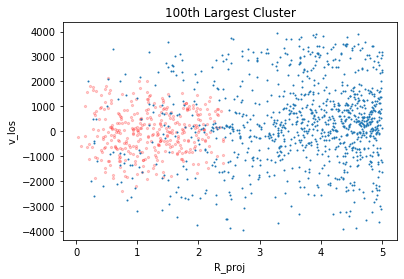

In [36]:
plt.figure()
plt.scatter(testdf[testdf.flag == 1][['R_proj']],testdf[testdf.flag == 1][['v_los']], s=5.,c='r',alpha=0.2)
plt.scatter(testdf[testdf.flag == 0][['R_proj']],testdf[testdf.flag == 0][['v_los']], s=1.)
plt.xlabel('R_proj')
plt.ylabel('v_los')
plt.title('100th Largest Cluster')

plt.show()

In [46]:
#img = np.reshape(testdf.R_proj,testdf.v_los)
img = np.array([100,100])

In [63]:
R_scale=100/max(testdf.R_proj)
V_scale=100/max(testdf.v_los-testdf.min(0)[3])


In [62]:
testdf.min(0)[3]

-3943.41

In [97]:

pos = testdf.R_proj*R_scale.apply(pd.to_numeric)
#, np.array(testdf.v_los*V_scale)

for x, y in pos:
    print(x,y)
    img[x, y] =1 

AttributeError: 'float' object has no attribute 'apply'

In [103]:

pos = testdf.R_proj.apply(pd.to_numeric)
print(pos)
pos[0]

310436    4.83903
310437    4.90959
310438    3.30520
310439    4.54956
310440    4.63954
           ...   
312565    4.04123
312566    1.97013
312567    1.43526
312568    3.41695
312569    1.42005
Name: R_proj, Length: 2134, dtype: float64


KeyError: 0

In [96]:
pos[1][1]

-26.978574330455736

In [87]:
pos[0]

array([96.78776229, 98.19906673, 66.10889206, ..., 28.70732434,
       68.34405746, 28.40310183])

In [107]:
p[*,0] = np.array(testdf.R_proj*R_scale)
p[*,1] = np.array(testdf.v_los*V_scale)

SyntaxError: invalid syntax (<ipython-input-107-c29a6ad9dabd>, line 1)

In [83]:
np.array(testdf.R_proj*R_scale).shape

(2134,)

# Making `X_train` and `y_train`

In [26]:
X_train = testdf.drop(["flag","x","y","proj_axis","cluster_id","gal_id","cluster_id_num","label"],axis=1)
y_train = testdf["label"].copy()

In [27]:
X_train?

In [28]:
y_train?

In [29]:
X_train.head()

,R_proj,v_los
310436,4.83903,-991.951
310437,4.90959,-2131.650
310438,3.30520,-3665.440
310439,4.54956,-2136.590
310440,4.63954,-1095.880


# Encoding

In [30]:
#encoding test

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer = SimpleImputer(strategy="median")
X_num = X_train
imputer.fit(X_num)

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])

#column transformer
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
])

X_train = full_pipeline.fit_transform(X_num)

In [31]:
X_train.dtype

dtype('float64')

In [32]:
y_train = y_train.values.astype('int64')

In [33]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

# Save the train set as a `pickle`

In [34]:
import pickle

pickle.dump([X_train, y_train], open( "cluster-mldata.plk", "wb" ) )

In [35]:
!ls *.plk

cluster-mldata.plk
